# Models 

In [1]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [2]:
meta = {}
meta[45] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_162032', 'del_units':[594], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[46] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_180855', 'del_units':None, 'vis_mice':np.array(['nan', 'alpha', 'beta'])}
meta[11] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-06_154258', 'del_units':[847, 835], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[13] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_120055', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[14] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_122629', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[19] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_140410', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[20] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_110539', 'del_units':[33], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}


In [3]:
Session = 14

In [4]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
active_blocks = [1,2,3]

In [5]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]
c_idx = 3 

In [6]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl')
except:
    pass

In [7]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl\\S{Session}')
except:
    pass

### Ephys data

In [8]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [9]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 14: 32 good clusters


In [10]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

In [11]:
len(goodspiketimes.keys())

32

### Behavior data

In [12]:
matfile =  f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [13]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [14]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12)

## Data prep: firing rate array

In [15]:
import copy

In [16]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=None):
    # discard wierd cells based on rasters
    goodspiketimes_copy = copy.deepcopy(goodspiketimes)

    try:
        for unit in del_units:
            del goodspiketimes_copy[unit]
    except:
        pass

    units = goodspiketimes_copy.keys()
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes_copy.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes_copy[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes_copy[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes_copy[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic
        

### Firing rates

firing rate [Hz] = spike_count/ time_window(sec)

* lets find it for each trial for each cell
* we will make an array where each row is trial; each column - neuron; we will collect it in dict where keys = blocks

In [17]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 0*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 0*samplplimg_rate # 1 sec
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s

binsize = 0.25*samplplimg_rate 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [18]:
# 250 ms during the nosepoke
fr_dic = fr_matrix_prep(beforesamples, aftersamples, blocks=active_blocks, bins=bins, del_units=del_units)

In [19]:
fr_dic.keys()

dict_keys([1, 2, 3])

In [20]:
fr_dic[1].shape

(30, 32)

## Classifiers

In [21]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import percentileofscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [22]:
# data prep
alpha_data = fr_dic[a_idx]
beta_data = fr_dic[b_idx]
blank_data = fr_dic[c_idx]

# random.seed(666)

num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))

random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]

random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

num_rows = alpha_data.shape[0]
social_data = np.concatenate((alpha_data[:int(num_rows/2),:], beta_data[int(num_rows/2):,:]), axis=0)

random.shuffle(shuffled_indices)
blank_data = blank_data[shuffled_indices]

alpha_data.shape, beta_data.shape, blank_data.shape, social_data.shape

((30, 32), (30, 32), (30, 32), (30, 32))

### SVC

#### GridSearch cv

In [23]:
def data_prep(alpha_data, beta_data): # not standartized!!!!
    # prepare dataset
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))

    random.seed(666)
    # alpha
    test_alpha_idx = random.sample(indices, 5)
    train_valid_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_valid_alpha = alpha_data[train_valid_alpha_idx]

    # beta
    test_beta_idx = random.sample(indices, 5)
    train_valid_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_valid_beta = beta_data[train_valid_beta_idx]

    # alphaa+beta datasets
    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_valid_ab = np.concatenate((train_valid_alpha,train_valid_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train_valid = np.concatenate((np.ones(train_valid_alpha.shape[0]),np.zeros(train_valid_beta.shape[0])))


    # randomize train
    num_rows = train_valid_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_valid_ab = train_valid_ab[shuffled_indices]
    y_train_valid = y_train_valid[shuffled_indices]

    return train_valid_ab, y_train_valid, test_ab, y_test

In [24]:
# alpha vs beta data
X_train_ab, y_train_ab, X_test_ab, y_test_ab = data_prep(alpha_data, beta_data)

X_train_ab.shape, y_train_ab.shape, X_test_ab.shape, y_test_ab.shape

((50, 32), (50,), (10, 32), (10,))

In [25]:
# social vs blank data
X_train_sb, y_train_sb, X_test_sb, y_test_sb = data_prep(social_data, blank_data)

X_train_sb.shape, y_train_sb.shape, X_test_sb.shape, y_test_sb.shape

((50, 32), (50,), (10, 32), (10,))

In [26]:
def gridsearchcv(X_train, y_train, X_test, y_test):
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']  # Only needed for non-linear kernels
    }

    # Initialize Grid Search with Cross-Validation
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred_ab = best_model.predict(X_test)


    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", accuracy_score(y_test_ab, y_pred_ab))
    print("Confusion Matrix:\n", confusion_matrix(y_test_ab, y_pred_ab))
    print("Classification Report:\n", classification_report(y_test_ab, y_pred_ab))

    return best_model, accuracy_score(y_test_ab, y_pred_ab)


In [27]:
best_model_svm_ab, accuracy_svm_ab = gridsearchcv(X_train_ab, y_train_ab, X_test_ab, y_test_ab)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.6
Confusion Matrix:
 [[4 1]
 [3 2]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.80      0.67         5
         1.0       0.67      0.40      0.50         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10



In [28]:
best_model_svm_sb, accuracy_svm_sb = gridsearchcv(X_train_sb, y_train_sb, X_test_sb, y_test_sb)

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 1.0
Confusion Matrix:
 [[5 0]
 [0 5]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



#### Old fashioned method

In [29]:
def SVM(alpha_data, beta_data, kernel = 'linear', cv=5):

    # random.seed(666)
    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = 6 # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # Standardize the data
        scaler = StandardScaler()
        test_ab = scaler.fit_transform(test_ab)
        train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel, random_state=666)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [30]:
acc_svm_ab = SVM(alpha_data, beta_data)
acc_svm_ab

0.65

In [31]:
acc_svm_sb = SVM(social_data, blank_data)
acc_svm_sb

0.95

In [32]:
acc_sh_ab = []
# shuffle trials
# random.seed(666)
shuffled_indices = list(range(len(alpha_data)*2))
for sh in range(1000):
    # data prep
    data_ab = np.concatenate((alpha_data,beta_data), axis=0)
    random.shuffle(shuffled_indices)
    # print(shuffled_indices)
    data_ab = data_ab[shuffled_indices]
    k = alpha_data.shape[0]
    a_sh = data_ab[:k]
    b_sh = data_ab[k:]
    
    acc_sh_ab.append(SVM(a_sh, b_sh))
    

In [33]:
acc_sh_sb = []
# shuffle trials
# random.seed(666)
shuffled_indices = list(range(len(social_data)*2))
for sh in range(1000):
    # data prep
    data_sb = np.concatenate((social_data,blank_data), axis=0)
    random.shuffle(shuffled_indices)
    # print(shuffled_indices)
    data_sb = data_sb[shuffled_indices]
    k = social_data.shape[0]
    s_sh = data_sb[:k]
    bl_sh = data_sb[k:]
    
    acc_sh_sb.append(SVM(s_sh, bl_sh))

In [34]:
acc_sh_ab_sorted = np.sort(np.array(acc_sh_ab))
percentile_rank = percentileofscore(acc_sh_ab_sorted, np.mean(acc_svm_ab))
# one-tailored
p_value_ab = 1-(percentile_rank/100)

In [35]:
acc_sh_sb_sorted = np.sort(np.array(acc_sh_sb))
percentile_rank = percentileofscore(acc_sh_sb_sorted, np.mean(acc_svm_sb))
# one-tailored
p_value_sb = 1-(percentile_rank/100)

In [36]:
#colors

# svm
Purple ='#800080' #sb
Tomato = '#FF6347' #ab

# bayes
MediumBlue = '#0000CD' #sb
HotPink = '#FF69B4' #ab

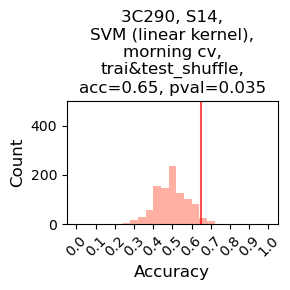

In [37]:
plt.figure(figsize=(3,3)) 
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh_ab, bins=bin_edges, alpha=0.5, color='#FF6347')
plt.axvline(acc_svm_ab,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,500)
plt.title(f'{mouse}, S{Session},\nSVM (linear kernel),\nmorning cv,\ntrai&test_shuffle,\nacc={acc_svm_ab:.2f}, pval={p_value_ab:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl\\S{Session}\\{mouse}_S{Session}_SVM_ab.png', dpi=300, bbox_inches='tight')
plt.show()

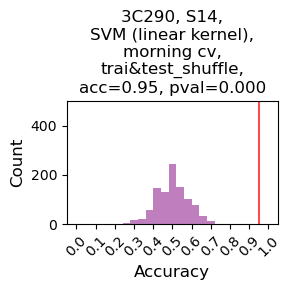

In [38]:
plt.figure(figsize=(3,3)) 
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh_sb, bins=bin_edges, alpha=0.5, color='#800080')
plt.axvline(acc_svm_sb,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,500)
plt.title(f'{mouse}, S{Session},\nSVM (linear kernel),\nmorning cv,\ntrai&test_shuffle,\nacc={acc_svm_sb:.2f}, pval={p_value_sb:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl\\S{Session}\\{mouse}_S{Session}_SVM_sb.png', dpi=300, bbox_inches='tight')
plt.show()

#### Bayes

In scikit-learn, there are several types of Naive Bayes classifiers, each suited for different types of data:

- **Gaussian Naive Bayes (GaussianNB):** Suitable for continuous data that follows a normal (Gaussian) distribution.
- **Multinomial Naive Bayes (MultinomialNB):** Suitable for discrete data (e.g., counts of occurrences in text classification).
- **Bernoulli Naive Bayes (BernoulliNB):** Suitable for binary/boolean data.
- **Complement Naive Bayes (ComplementNB):** Designed to handle imbalanced datasets, particularly in text classification.
- **Categorical Naive Bayes (CategoricalNB):** Suitable for categorical features (new in scikit-learn 0.24).


Choosing the Right Naive Bayes Classifier:

- **GaussianNB**: Use this if your features are continuous and you assume they follow a Gaussian distribution.
- **MultinomialNB**: Use this if your features are counts or frequencies (e.g., term frequencies in text data).
- **BernoulliNB**: Use this if your features are binary (0 or 1).
- **ComplementNB**: Use this if you have an imbalanced dataset, especially in text classification.
- Catego**ricalNB: Use this if your features are categorical.


---> we will use **GaussianNB**

---> # There are no hyperparameters for GaussianNB to tune with GridSearchCV

In [39]:
def bayes(alpha_data, beta_data, cv=5):

    # random.seed(666)
    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = 6 # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # # Standardize the data
        # scaler = StandardScaler()
        # test_ab = scaler.fit_transform(test_ab)
        # train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        bayes_classifier_cv = GaussianNB()
        bayes_classifier_cv.fit(train_ab, y_train)
        y_pred = bayes_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [40]:
acc_bayes_ab = bayes(alpha_data, beta_data)
acc_bayes_ab

0.6166666666666667

In [41]:
acc_bayes_sb = bayes(social_data, blank_data)
acc_bayes_sb

0.9166666666666666

In [42]:
acc_sh_bayes_ab = []
# shuffle trials
# random.seed(666)
shuffled_indices = list(range(len(alpha_data)*2))
for sh in range(1000):
    # data prep
    data_ab = np.concatenate((alpha_data,beta_data), axis=0)
    random.shuffle(shuffled_indices)
    # print(shuffled_indices)
    data_ab = data_ab[shuffled_indices]
    k = alpha_data.shape[0]
    a_sh = data_ab[:k]
    b_sh = data_ab[k:]
    
    acc_sh_bayes_ab.append(bayes(a_sh, b_sh))

In [43]:
acc_sh_bayes_sb = []
# shuffle trials
# random.seed(666)
shuffled_indices = list(range(len(social_data)*2))
for sh in range(1000):
    # data prep
    data_sb = np.concatenate((social_data,blank_data), axis=0)
    random.shuffle(shuffled_indices)
    # print(shuffled_indices)
    data_sb = data_sb[shuffled_indices]
    k = social_data.shape[0]
    s_sh = data_sb[:k]
    bl_sh = data_sb[k:]
    
    acc_sh_bayes_sb.append(bayes(s_sh, bl_sh))

In [44]:
acc_sh_bayes_ab_sorted = np.sort(np.array(acc_sh_bayes_ab))
percentile_rank = percentileofscore(acc_sh_bayes_ab_sorted, np.mean(acc_bayes_ab))
# one-tailored
p_value_bayes_ab = 1-(percentile_rank/100)

In [45]:
acc_sh_bayes_sb_sorted = np.sort(np.array(acc_sh_bayes_sb))
percentile_rank = percentileofscore(acc_sh_bayes_sb_sorted, np.mean(acc_bayes_sb))
# one-tailored
p_value_bayes_sb = 1-(percentile_rank/100)

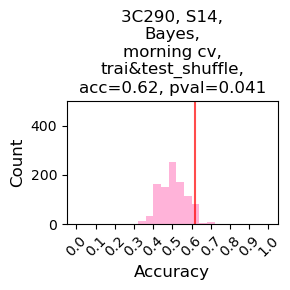

In [46]:
plt.figure(figsize=(3,3)) 
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh_bayes_ab, bins=bin_edges, alpha=0.5, color='#FF69B4')
plt.axvline(acc_bayes_ab,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,500)
plt.title(f'{mouse}, S{Session},\nBayes,\nmorning cv,\ntrai&test_shuffle,\nacc={acc_bayes_ab:.2f}, pval={p_value_bayes_ab:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl\\S{Session}\\{mouse}_S{Session}_Bayes_ab.png', dpi=300, bbox_inches='tight')
plt.show()

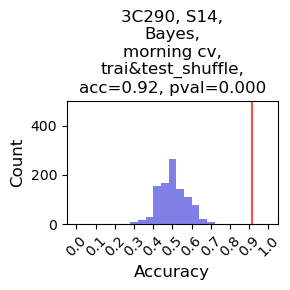

In [47]:
plt.figure(figsize=(3,3)) 
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh_bayes_sb, bins=bin_edges, alpha=0.5, color='#0000CD')
plt.axvline(acc_bayes_sb,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,500)
plt.title(f'{mouse}, S{Session},\nBayes,\nmorning cv,\ntrai&test_shuffle,\nacc={acc_bayes_sb:.2f}, pval={p_value_bayes_sb:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl\\S{Session}\\{mouse}_S{Session}_Bayes_sb.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
classifiers_results = {}
classifiers_results['svm'] = {'acc_ab':acc_svm_ab, 'acc_sh_ab':acc_sh_ab, 'pval_ab':p_value_ab, 
                              'acc_sb':acc_svm_sb, 'acc_sh_sb':acc_sh_sb, 'pval_sb':p_value_sb}

classifiers_results['bayes'] = {'acc_ab':acc_bayes_ab, 'acc_sh_ab':acc_sh_bayes_ab,'pval_ab':p_value_bayes_ab, 
                                'acc_sb':acc_bayes_sb, 'acc_sh_sb':acc_sh_bayes_sb, 'pval_sb':p_value_bayes_sb}

In [49]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_a_b_bl\\S{Session}\\{mouse}_S{Session}_classifiers_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(classifiers_results, f)

In [50]:
# # load
# with open(save_path, 'rb') as f:
#     classifiers_results = pickle.load(f)
# classifiers_results